## In this coding discussion, we will walk you through some basic preprocessing techniques that will help you achieve some performance boost.

#### This notebook has been created by Tonmoy.

## (i) Importing the necessary packages

In [59]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

## (ii)(a) Loading and visualizing the dataset 

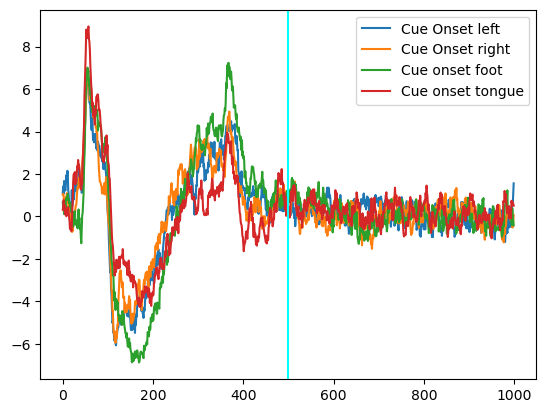

In [60]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,9,:] # extracts the 9th (out of 22) channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



## (ii)(b) Preprocessing the dataset

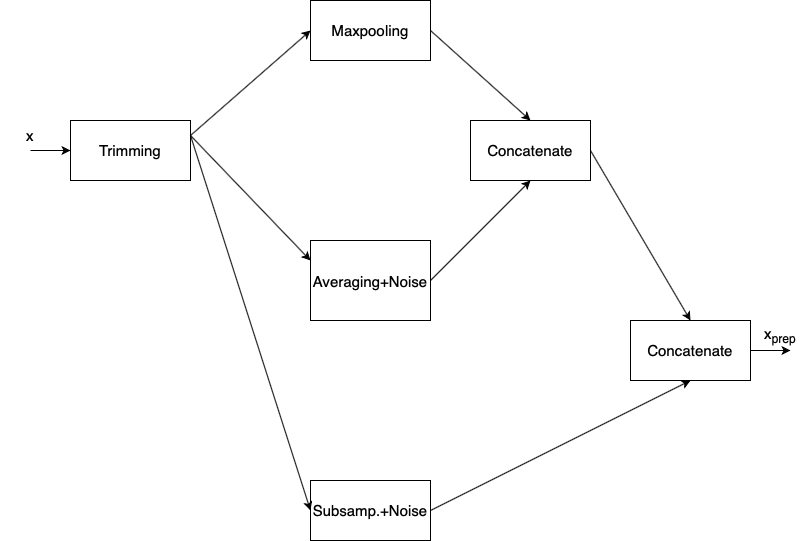

In [61]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    

    #data augmentation
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


## (ii)(c) Preparing the training, validation, and test datasets

In [62]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
print("training data")
x_train,y_train = data_prep(X_train,y_train,2,2,True)
print("\nvalidation data")
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
print("\ntest data")
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)




training data
Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)

validation data
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)

test data
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validatio

## (iii)(CNN) Defining the architecture of a basic CNN model

In [63]:
def build_model(params):
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()

    #tune number of filters
    filter1 = params.Int('filter1', min_value =15, max_value = 30, step = 5)
    filter2 = params.Int('filter2', min_value =40, max_value = 60, step = 5)
    filter3 = params.Int('filter3', min_value =80, max_value = 120, step = 10)
    filter4 = params.Int('filter4', min_value =180, max_value = 220, step = 10)



    #tune kernel size
    kernel = params.Choice('kernel_size', values=[3,5,10])
    #tune pool size
    pool = params.Choice('pool_size', values=[2,3,5])
    #tune dropout
    dropout = params.Choice('dropout', values=[0.5,0.6,0.8])

    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=filter1, kernel_size=(kernel,1), padding='same', activation='elu', input_shape=(250,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(pool,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(dropout))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=filter2, kernel_size=(kernel,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(pool,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(dropout))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=filter3, kernel_size=(kernel,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(pool,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(dropout))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=filter4, kernel_size=(kernel,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(pool,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(dropout))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Printing the model summary
    # basic_cnn_model.summary()

    learning_rate = params.Choice('learning_rate', values = [1e-2, 1e-3, 5e-3])
    # epochs = 50
    cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

    # Compiling the model
    basic_cnn_model.compile(loss='categorical_crossentropy',
                    optimizer=cnn_optimizer,
                    metrics=['accuracy'])
    
    return basic_cnn_model
    


## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [64]:
# Model parameters
# learning_rate = 1e-3
# epochs = 50
# cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

#early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 20,
                    overwrite=True)
tuner.search(x_train,y_train,epochs=80,validation_data=(x_valid,y_valid), callbacks = [callback])


Trial 20 Complete [00h 02m 43s]
val_accuracy: 0.7200000286102295

Best val_accuracy So Far: 0.7293333411216736
Total elapsed time: 00h 24m 08s
INFO:tensorflow:Oracle triggered exit


## (v)(CNN) Compiling, training and validating the model

In [73]:

#train with best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50,batch_size=64, validation_data=(x_valid, y_valid)) 

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))



Epoch 1/50
109/109 [==============================] - 3s 21ms/step - loss: 1.9878 - accuracy: 0.3111 - val_loss: 1.1977 - val_accuracy: 0.4500
Epoch 2/50
109/109 [==============================] - 2s 18ms/step - loss: 1.5604 - accuracy: 0.3757 - val_loss: 1.1692 - val_accuracy: 0.4767
Epoch 3/50
109/109 [==============================] - 2s 19ms/step - loss: 1.3364 - accuracy: 0.4361 - val_loss: 1.1238 - val_accuracy: 0.5073
Epoch 4/50
109/109 [==============================] - 2s 18ms/step - loss: 1.2386 - accuracy: 0.4655 - val_loss: 1.0799 - val_accuracy: 0.5360
Epoch 5/50
109/109 [==============================] - 2s 18ms/step - loss: 1.1656 - accuracy: 0.5010 - val_loss: 1.1581 - val_accuracy: 0.4827
Epoch 6/50
109/109 [==============================] - 2s 18ms/step - loss: 1.1163 - accuracy: 0.5259 - val_loss: 1.0731 - val_accuracy: 0.5633
Epoch 7/50
109/109 [==============================] - 2s 17ms/step - loss: 1.0704 - accuracy: 0.5496 - val_loss: 0.9826 - val_accuracy: 0.5907

## (vi)(CNN) Visualizing the accuracy and loss trajectory

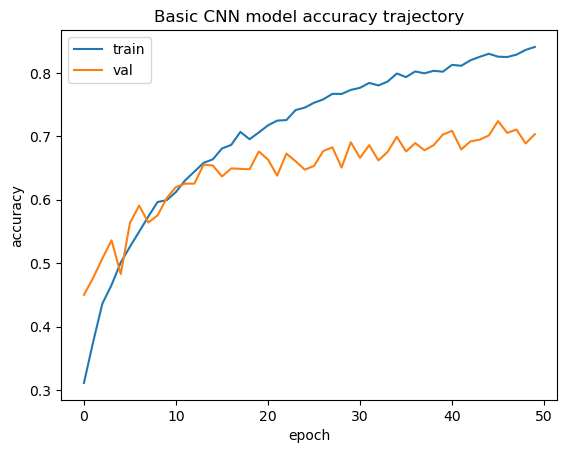

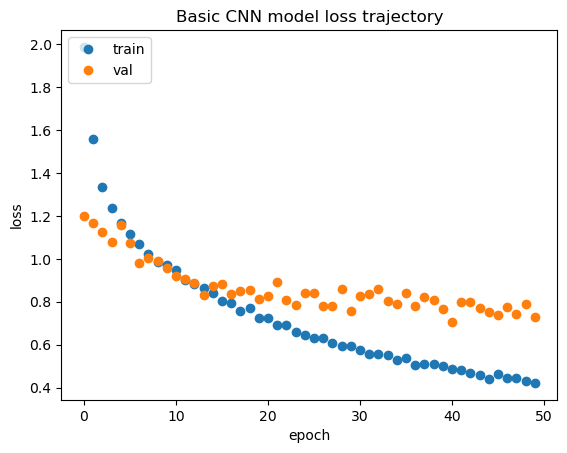

In [74]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [75]:
## Testing the basic CNN model

cnn_score = hypermodel.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])
print(best_hps.values)

Test accuracy of the basic CNN model: 0.7082392573356628
{'filter1': 30, 'filter2': 60, 'filter3': 100, 'filter4': 210, 'kernel_size': 5, 'pool_size': 3, 'dropout': 0.5, 'learning_rate': 0.001}
